In [1]:
!python -m pip install multiple-hypothesis-testing

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    # import glob; print(glob.glob('/content/gdrive/Othercomputers/My Laptop/projects/RUNI/Thesis/*'))
    import sys
    sys.path.append('/content/gdrive/Othercomputers/My Laptop/projects/RUNI/Thesis')
except:
    pass

In [3]:
from Synthetic_Data_Generators import Multi_Class_Normal_Population as Data_Generator
from Synthetic_Data_Generators import Two_Lists_Tuple
from Higher_Criticism import Higher_Criticism
higher_criticism = Higher_Criticism(gamma=1.0)

In [4]:
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import functools
from sklearn import metrics

plt.rcParams['font.family'] = 'monospace'


In [5]:

N = 1000
monte_carlo=10000
alpha = 0.05

parameters_tuple = [(0.,0.), (1., 0.01), (1.5, 0.01), (2., 0.01), (3., 0.01), (1., 0.02), (1., 0.03), (1., 0.05)]
collected_data = []
for mu, fraction in parameters_tuple:
    print(f'Collecting measurments for signal mu={mu:.2f} signal size={fraction*100:.2f}%')
    n = max(int(N*fraction),1)
    data_generator = Data_Generator(sizes=[N-n,n], mus=[0,mu], sigmas=[1,1])
    res_monte_carlo = higher_criticism.monte_carlo_statistics(monte_carlo=monte_carlo, data_generator=data_generator)
    collected_data.append((mu, fraction,res_monte_carlo))

baseline_noise = collected_data[0][2]
collected_data = collected_data[1:]


100%|██████████| 100/100 [00:03<00:00, 30.07it/s]


100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


100%|██████████| 100/100 [00:03<00:00, 26.41it/s]


100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


100%|██████████| 100/100 [00:03<00:00, 26.36it/s]


100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


100%|██████████| 100/100 [00:03<00:00, 30.60it/s]


100%|██████████| 100/100 [00:03<00:00, 30.12it/s]


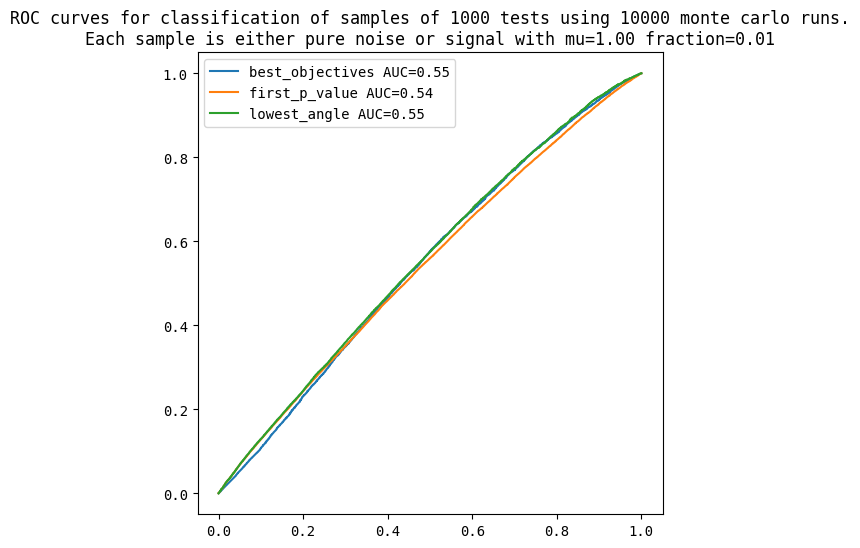

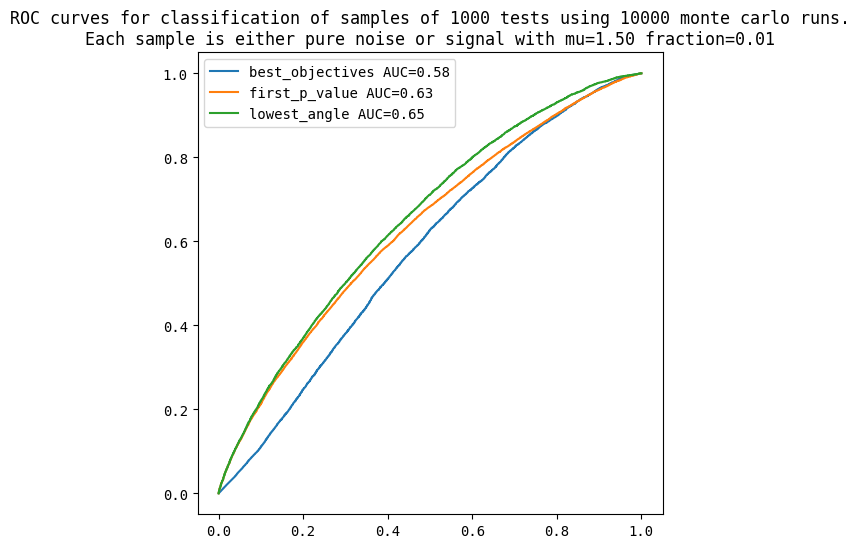

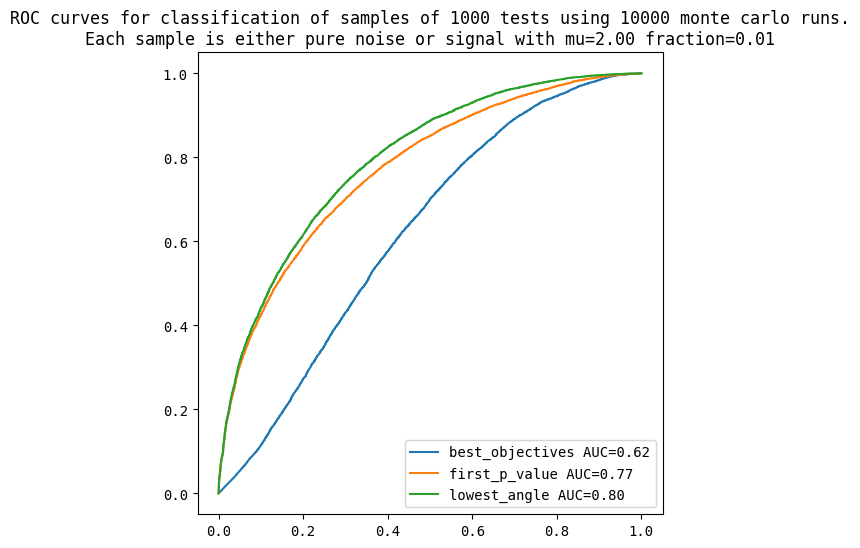

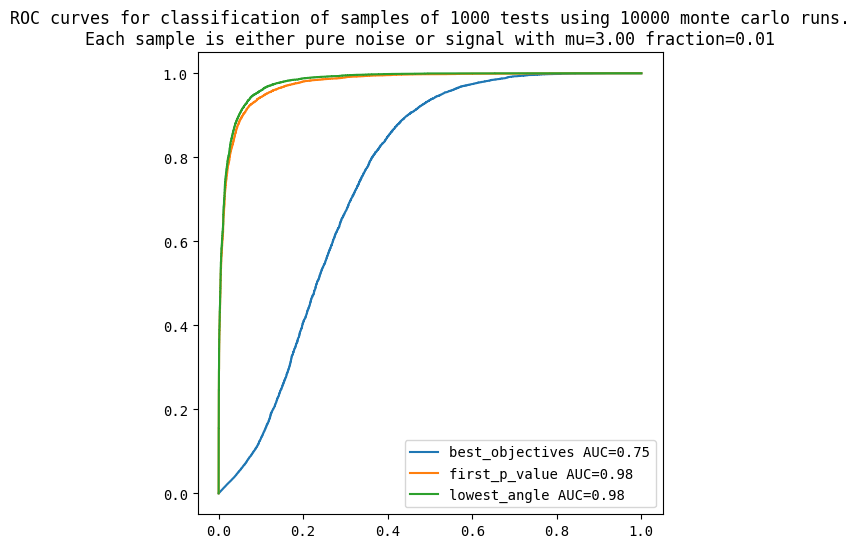

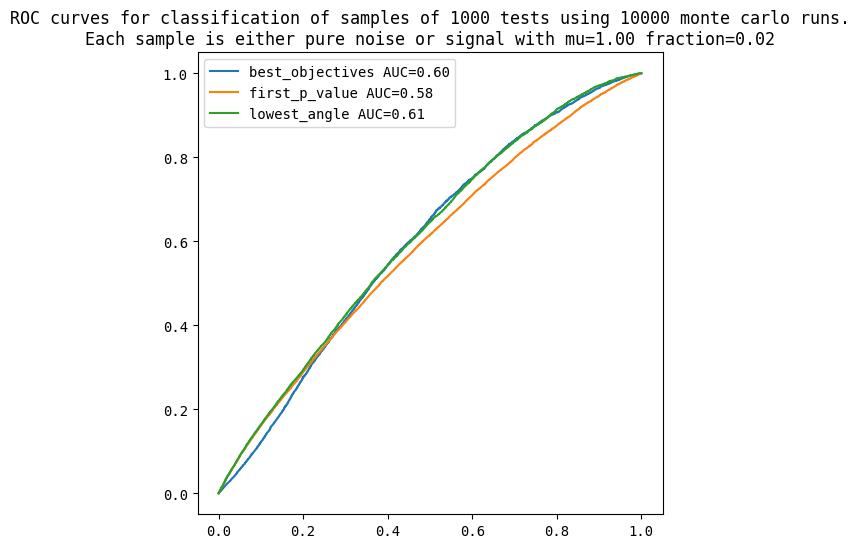

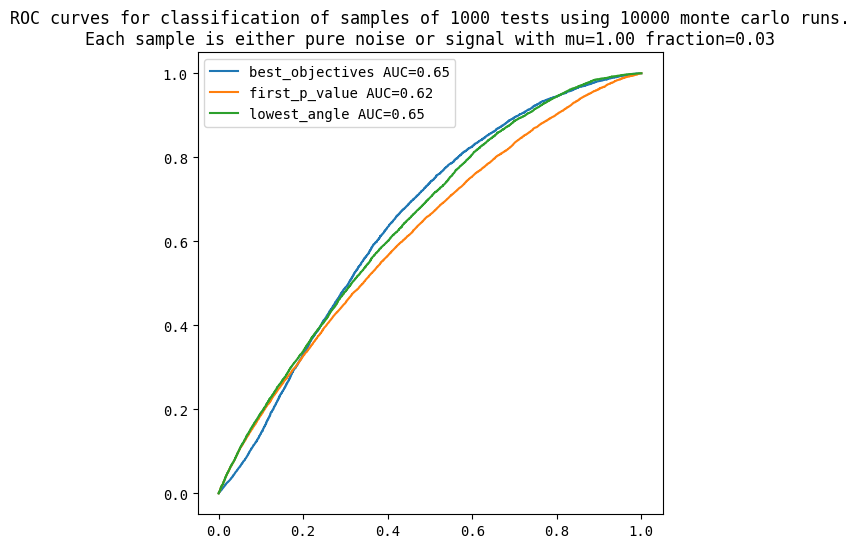

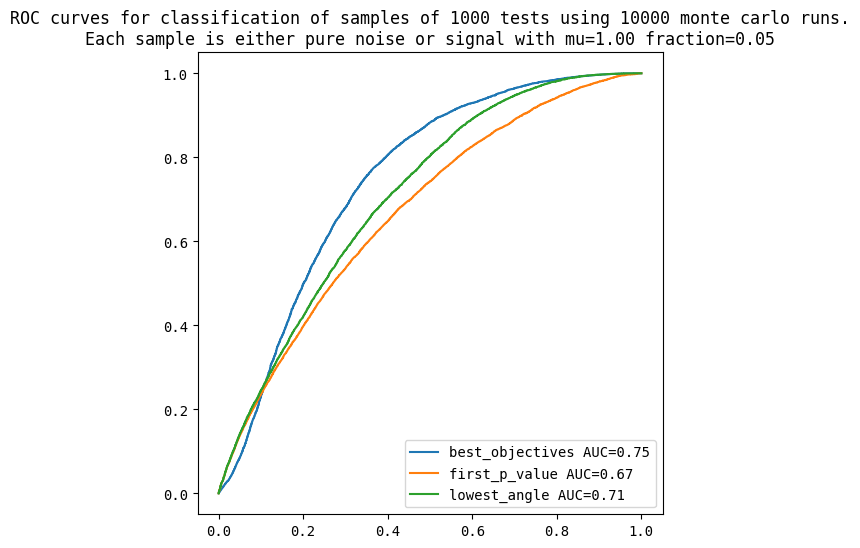

In [6]:
auc_results = {}
for mu, fraction, singal_res in collected_data:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    for key, baseline_values in baseline_noise.items():
        if key in ['nums_rejected', 'first_drawdown']:
            continue
        signal_values = singal_res[key]
        sort_v_factor = -1 if np.mean(signal_values) > np.mean(baseline_values) else 1
        roc_values_tuples = []
        for v in baseline_values:
            roc_values_tuples.append((0,v*sort_v_factor))
        for v in signal_values:
            roc_values_tuples.append((1,v*sort_v_factor))
        def cmp_signal_values(t1, t2):
            v1, v2 = t1[1], t2[1]
            diff_v12 = v1 - v2
            if abs(diff_v12) <= 1e-6*min(abs(v1),abs(v2)):
                return t1[0] - t2[0]
            return 1 if v1 > v2 else -1
        sorted_tuples = sorted(roc_values_tuples, key = functools.cmp_to_key(cmp_signal_values))
        sorted_labels = [roc_tuple[0] for roc_tuple in sorted_tuples]
        sorted_values = [roc_tuple[1] for roc_tuple in reversed(sorted_tuples)]
        y_pred=[1]*len(signal_values) + [0]*len(baseline_values)
        fpr, tpr, _ = metrics.roc_curve(y_true=sorted_labels, y_score= sorted_values)
        roc_auc = metrics.auc(fpr,tpr)
        ax.plot(fpr, tpr, label=key + f' AUC={roc_auc:.2f}')
    ax.set_title(f'ROC curves for classification of samples of {N} tests using {monte_carlo} monte carlo runs.\n'\
                 + f'Each sample is either pure noise or signal with mu={mu:.2f} fraction={fraction:.2f}')
    plt.legend()
    plt.show()
